## EDA template

In [1]:
import numpy as np
import pandas as pd
import pandas_profiling as pp
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
raw_df_full = pd.read_csv('data/Train.zip')

/Users/franzmornau/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (13,39,40,41) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


sampling to reduce size:

In [3]:
raw_df = raw_df_full[::10].reset_index()

* An alternative method is: f_test = raw_df.sample(10000)
* downside: every run you get a different result

# 1. Data Analysis
#### Meta data
* How many samples and features?
* What features are numeric vs. categorical

#### Data
* Inconsistent value types
* Missing values
* Zero values
* Incorrect values: sold before manufactured

In [4]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40113 entries, 0 to 40112
Data columns (total 54 columns):
index                       40113 non-null int64
SalesID                     40113 non-null int64
SalePrice                   40113 non-null int64
MachineID                   40113 non-null int64
ModelID                     40113 non-null int64
datasource                  40113 non-null int64
auctioneerID                38141 non-null float64
YearMade                    40113 non-null int64
MachineHoursCurrentMeter    14229 non-null float64
UsageBand                   6942 non-null object
saledate                    40113 non-null object
fiModelDesc                 40113 non-null object
fiBaseModel                 40113 non-null object
fiSecondaryDesc             26422 non-null object
fiModelSeries               5669 non-null object
fiModelDescriptor           7216 non-null object
ProductSize                 19076 non-null object
fiProductClassDesc          40113 non-null object

In [5]:
pp.ProfileReport(raw_df)

Number of variables,54
Number of observations,40113
Total Missing (%),53.5%
Total size in memory,16.5 MiB
Average record size in memory,432.0 B
Numeric,9
Categorical,44
Boolean,0
Date,0
Text (Unique),0
Rejected,0


In [6]:
# pd.plotting.scatter_matrix(raw_df)
# better use seaborn pairplot, see next cell

In [7]:
# sns.pairplot(raw_df)

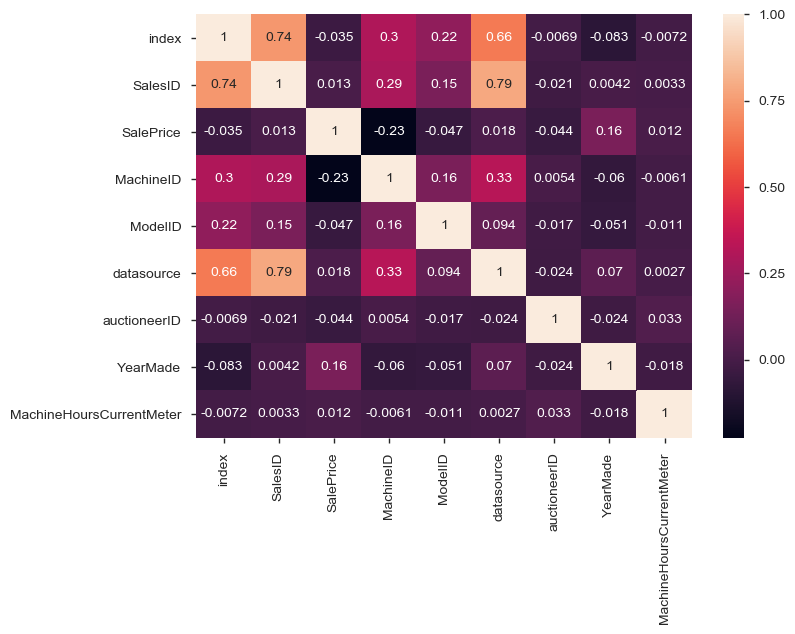

In [8]:
# Useful to get actual correlation numbers
sns.heatmap(raw_df.corr(), annot=True)

In [9]:
# plt.scatter(raw_df['YearMade'], dt.date2num(pd.to_datetime(raw_df['saledate'])))

# 2. Data Cleaning and Preparation
## 2.1 Dates to numerical

In [10]:
# getting correlations with dates by using date2num
import matplotlib.dates as dt

In [11]:
raw_df.head()

,index,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,0,1139246,66000,999089,3157,121,3.0,2004,68.0,Low,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,10,1139278,24000,1024998,4605,121,3.0,2004,1414.0,Medium,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,20,1139311,41000,1014135,8867,121,3.0,2000,3259.0,Medium,...,32 inch,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
3,30,1139363,51000,871201,1263,121,3.0,1999,15633.0,High,...,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
4,40,1139412,39000,108090,1088,121,3.0,2006,1125.0,Medium,...,None or Unspecified,None or Unspecified,Hydraulic,Yes,Triple,NaN,NaN,NaN,NaN,NaN


In [12]:
dt.date2num(pd.to_datetime(raw_df['saledate'][11]))
#type(raw_df['saledate'][3])

732267.0

In [13]:
dateNum = dt.date2num(pd.to_datetime(raw_df['saledate']))
type(dateNum)

numpy.ndarray

In [14]:
len(dateNum)

40113

## 2.2 Fill missing values

* replace the implausible values of YearMade by using KNN

In [15]:
from sklearn.neighbors import KNeighborsRegressor

* create a reduced DF with only 3 features (which we will use these for KNN)
* prepare for model fit by separating out the target

In [16]:
X_all = raw_df[['ModelID','YearMade']].copy()                  #produces a DataFrame! type(X)

In [17]:
X_all.describe()

,ModelID,YearMade
count,40113.000000,40113.000000
mean,6905.466981,1898.589186
std,6256.631237,292.562341
min,28.000000,1000.000000
25%,3261.000000,1985.000000
50%,4604.000000,1995.000000
75%,8724.000000,2000.000000
max,37198.000000,2011.000000


In [18]:
X_all.loc[:,'saledate_num'] = pd.Series(dateNum)
X_all.head(1)

,ModelID,YearMade,saledate_num
0,3157,2004,732631.0


In [19]:
X_KNN = X_all[X_all['YearMade']>1000].copy()
y_knn = X_KNN['YearMade']
X_KNN.drop('YearMade',axis=1,inplace=True)
X_KNN.describe()

,ModelID,saledate_num
count,36272.000000,36272.000000
mean,6787.061011,731758.462340
std,6163.405030,2128.963573
min,28.000000,726133.000000
25%,3261.000000,730383.000000
50%,4603.000000,732371.000000
75%,8247.000000,733471.000000
max,37198.000000,734501.000000


* create and fit the KNN model:

In [20]:
neigh = KNeighborsRegressor(n_neighbors=2)
neigh.fit(X_KNN, y_knn) 

# neigh.predict(X_KNN)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=2, p=2,
          weights='uniform')

In [21]:
X_to_fill = X_all[X_all['YearMade'] <= 1000].copy()
X_to_fill.drop('YearMade',axis=1,inplace=True)

In [22]:
year_predicted = neigh.predict(X_to_fill)

In [23]:
len(X_to_fill)

3841

In [24]:
year_predicted

array([1986. , 1996.5, 1999. , ..., 1996.5, 1997.5, 2006. ])

In [25]:
X_all.loc[X_all['YearMade'] <= 1000, 'YearMade'] = year_predicted

In [26]:
X_all.describe()

,ModelID,YearMade,saledate_num
count,40113.000000,40113.000000,40113.000000
mean,6905.466981,1993.801411,731799.155037
std,6256.631237,9.473038,2097.259788
min,28.000000,1919.000000,726133.000000
25%,3261.000000,1988.000000,730397.000000
50%,4604.000000,1996.000000,732393.000000
75%,8724.000000,2001.000000,733485.000000
max,37198.000000,2011.000000,734501.000000


* quick check:

In [27]:
X_all.loc[X_all['YearMade'] <= 1000].head()

,ModelID,YearMade,saledate_num


- we replaced all the implausible YearMade values with plausible ones. No '1000's anymore. 

# 3 Linear Regression

In [28]:
import statsmodels.api as sm

In [29]:
raw_df['ModelID'].head()

0    3157
1    4605
2    8867
3    1263
4    1088
Name: ModelID, dtype: int64

In [30]:
X_all['ModelID'].head()

0    3157
1    4605
2    8867
3    1263
4    1088
Name: ModelID, dtype: int64

In [31]:
X = X_all
y = raw_df['SalePrice']

In [32]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40113 entries, 0 to 40112
Data columns (total 3 columns):
ModelID         40113 non-null int64
YearMade        40113 non-null float64
saledate_num    40113 non-null float64
dtypes: float64(2), int64(1)
memory usage: 940.2 KB


In [33]:
model = sm.OLS(y, X)
results = model.fit()
results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.668
Model:                            OLS   Adj. R-squared:                  0.668
Method:                 Least Squares   F-statistic:                 2.686e+04
Date:                Wed, 12 Jun 2019   Prob (F-statistic):               0.00
Time:                        11:10:04   Log-Likelihood:            -4.5847e+05
No. Observations:               40113   AIC:                         9.169e+05
Df Residuals:                   40110   BIC:                         9.170e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
ModelID         -0.3273      0.018    -18.146      0.000      -0.363      -0.292
YearMade       740.8371     15.034     49.277      0.000     711.370     770.304
saledate_num    -1.9729      0.041    -48.200      0.000      -2.053      -1.893
==============================================================================
Omnibus:                    10529.604   Durbin-Watson:                   0.782
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            24219.750
Skew:                           1.495   Prob(JB):                         0.00
Kurtosis:                       5.357   Cond. No.                     9.90e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.9e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [34]:
X.head()

,ModelID,YearMade,saledate_num
0,3157,2004.0,732631.0
1,4605,2004.0,733275.0
2,8867,2000.0,732449.0
3,1263,1999.0,734067.0
4,1088,2006.0,733583.0


In [35]:
results.predict(X).head()

0    38190.681841
1    36446.170428
2    33717.408100
3    32273.343739
4    38471.371811
dtype: float64

In [36]:
type(X)

pandas.core.frame.DataFrame

## Test Score

In [37]:
X_test = pd.read_csv('data/Test.zip')

In [38]:
df_sol = pd.read_csv("data/do_not_open/test_soln.csv.zip")

dateNum = dt.date2num(pd.to_datetime(X_test['saledate']))
X_test['saledate_num'] = pd.Series(dateNum)
X_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,...,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saledate_num
0,1222837,902859,1376,121,3,1000,0.0,NaN,1/5/2012 0:00,375L,...,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN,734507.0
1,1222839,1048320,36526,121,3,2006,4412.0,Medium,1/5/2012 0:00,TX300LC2,...,"12' 4""",None or Unspecified,Yes,Double,NaN,NaN,NaN,NaN,NaN,734507.0
2,1222841,999308,4587,121,3,2000,10127.0,Medium,1/5/2012 0:00,270LC,...,"12' 4""",None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN,734507.0
3,1222843,1062425,1954,121,3,1000,4682.0,Low,1/5/2012 0:00,892DLC,...,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN,734507.0
4,1222845,1032841,4701,121,3,2002,8150.0,Medium,1/4/2012 0:00,544H,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional,734506.0


In [39]:
def score(self, predictions):
        log_diff = np.log(predictions+1) - np.log(self+1)
        return np.sqrt(np.mean(log_diff**2))

In [40]:
X_test = X_test[['ModelID','YearMade','saledate_num']]

In [41]:
# X_train = X_test[X_all['YearMade']>1000]
# y = X_train['YearMade']
# X_train.drop('YearMade',axis=1,inplace=True)
# X_train.head()

In [42]:
X_t_to_fill = X_test[X_test['YearMade'] <= 1500].copy()
X_t_to_fill.drop('YearMade',axis=1,inplace=True)

In [54]:
year_predicted_t = neigh.predict(X_t_to_fill)
X_test.loc[X_test['YearMade'] <= 1000, 'YearMade'] = pd.DataFrame(year_predicted_t)

In [55]:
year_predicted_t

array([1998.5, 1996. , 1989. , ..., 2005. , 1999.5, 2004.5])

In [56]:
X_test.iloc[0]

ModelID           1376.0
YearMade          1998.0
saledate_num    734507.0
Name: 0, dtype: float64

In [57]:
type(X_test)

pandas.core.frame.DataFrame

In [58]:
test_prediction = results.predict(X_test)

In [59]:
len(test_prediction)

11573

In [52]:
rmsle = score(df_sol["SalePrice"], test_prediction)
rmsle

/Users/franzmornau/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


In [50]:
X.columns

Index(['ModelID', 'YearMade', 'saledate_num'], dtype='object')